In [5]:
from HySpec_Image_Processing import HDR_Image
from get_pixel_mosaic import create_arrays
from M3_UnZip import M3_unzip
import os
import matplotlib.pyplot as plt
import numpy as np
from fancy_spec_plot import fancy_spec_plot
from spec_average import spec_avg
from scipy import interpolate as interp
from matplotlib.animation import FuncAnimation
from cubic_spline_image import cubic_spline_image
from cubic_spline_image import removeNAN
import spectral as sp

##### Getting necessary data arrays and M3 stamp list

In [7]:
if 'shadow' not in locals():
    shadow,imgStats,mosaicArray,mosaicStats = create_arrays(r'D:/Data')
    print ('Arrays Loaded')
elif 'shadow' in locals():
    print ('Arrays Exist')

hdrFileList,hdrFilesPath = M3_unzip(select=False,folder=r'D:/Data/20230209T095534013597')
stampList = []
for file in hdrFileList:
    stampList.append(HDR_Image(os.path.join(hdrFilesPath,file)))

Arrays Exist
.zip Files have already been extracted


##### Getting average reflectance of South Pole (R<sub>bi</sub>)

In [13]:
def get_avg_rfl_data(stampList,plot_data=False):
    wvl = stampList[0].hdr.bands.centers[2:]
    rfl_avgSouthPole=np.zeros(83)
    rfl_stdSouthPole=np.zeros(83)
    for n in range(mosaicArray.shape[0]):
        rfl_avgSouthPole[n] = np.average(mosaicArray[n,:])
        rfl_stdSouthPole[n] = np.std(mosaicArray[n,:])

    
    # Plots Average Reflectance Data
    if plot_data == True:
        fig,ax = plt.subplots(1,1)
        fancy_spec_plot(fig,ax,wvl[21:73],rfl_avgSouthPole[21:73],std=rfl_stdSouthPole[21:73],
                        title="Average Reflectance of Non-Shaded Lunar South Pole",
                        ylabel= 'Reflectance', xlabel = 'Wavelength (\u03BCm)')
        
    return wvl,rfl_avgSouthPole,rfl_stdSouthPole

##### Makes shadow correction as in Li et al., 2018

Obtaining average south pole reflectance (R_bi)...
R_bi obtained
Obtaining original reflectance image (R_meas)...
R_meas Obtained
Running Li et al. Correction...


C:\Users\zacha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


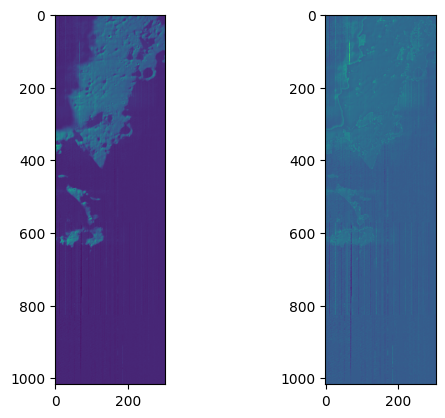

Corrected wavelengths calculated and plotted


In [31]:
print ('Obtaining average south pole reflectance (R_bi)...')
wvl, rfl_avgSP, rfl_stdSP = get_avg_rfl_data(stampList, plot_data=False)
wvl = np.array(wvl)
allowedIndices = np.where((wvl>900)&(wvl<2600))[0]
allowedWvl = wvl[allowedIndices]
R_bi = rfl_avgSP[allowedIndices]
print ('R_bi obtained')

print ('Obtaining original reflectance image (R_meas)...')
hdr = sp.envi.open(r"D:/Data/20230209T095534013597/extracted_files/hdr_files/m3g20090417t193320_v01_rfl/m3g20090417t193320_v01_rfl.hdr")
R_c = hdr.read_bands(allowedIndices) # To fill in corrected values.
R_meas = hdr.read_bands(allowedIndices)
print ('R_meas Obtained')

print ('Running Li et al. Correction...')
xShade,yShade = np.where(shadow[0]==0)
xLight,yLight = np.where(shadow[0]!=0)
R_c[xShade,yShade,:] = R_c[xShade,yShade,:]/R_bi

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(R_meas[:,:,0])
ax2.imshow(R_c[:,:,0])
plt.show()
print ('Corrected wavelengths calculated and plotted')

##### Applying cubic spline correction to spectrum values

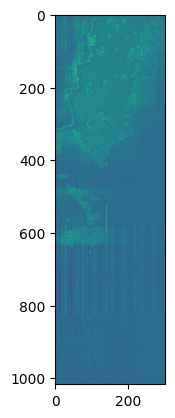

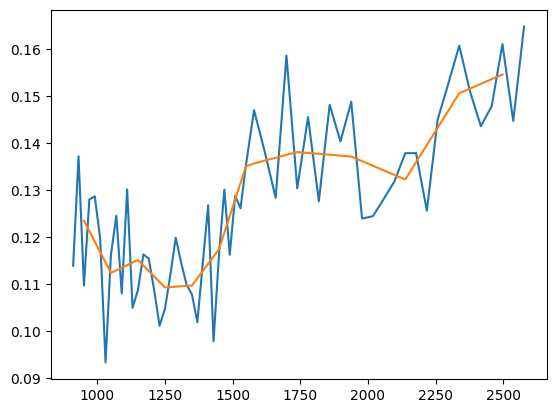

In [49]:
#spectrumImage_avg,spectrumImage_cspl = cubic_spline_image(R_c,allowedWvl,5)
#plt.imshow(spectrumImage_avg[:,:,2])

##### Plotting some pixel values

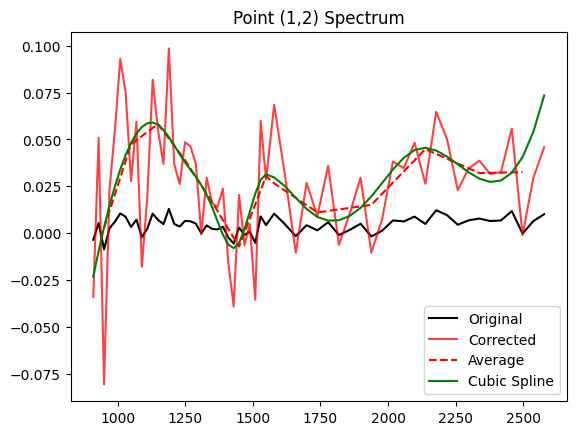

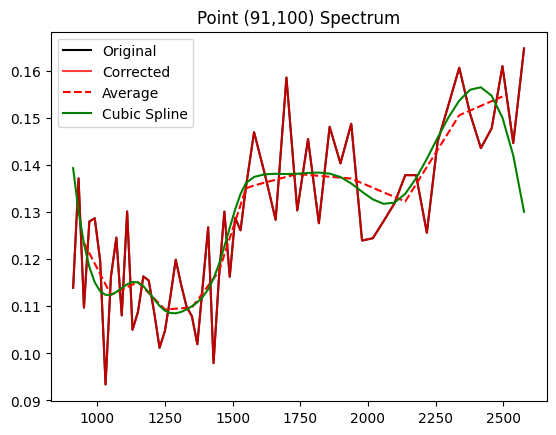

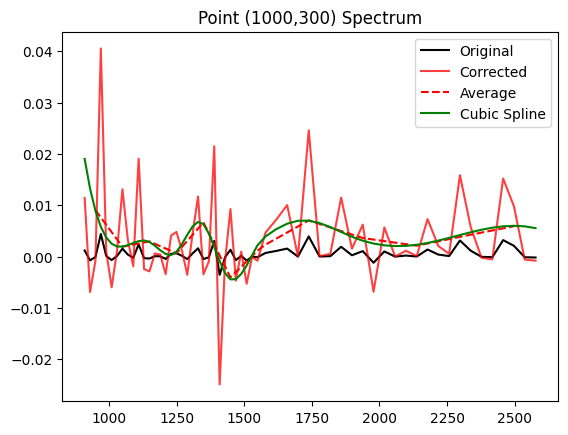

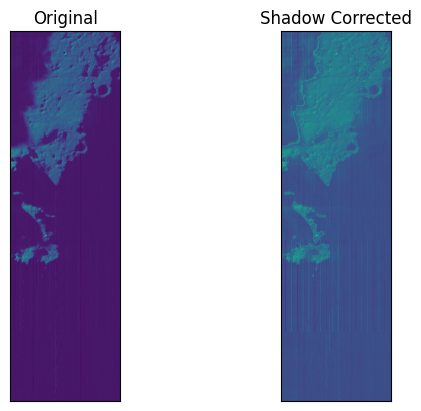

In [59]:
def plot_correction(x,y):
    fig,ax = plt.subplots(1,1)
    ax.plot(allowedWvl,R_meas[x,y,:],label='Original',color='k')
    ax.plot(allowedWvl,R_c[x,y,:],label='Corrected',color='red',alpha=0.75)
    ax.plot(allowedWvl,spectrumImage_avg[x,y,:],label='Average',color='red',ls='--')
    ax.plot(allowedWvl,spectrumImage_cspl[x,y,:],label='Cubic Spline',color='Green')
    ax.set_title(f'Point ({x},{y}) Spectrum')
    ax.legend()
plot_correction(1,2)
plot_correction(91,100)
plot_correction(1000,300)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_title('Original')
ax2.set_title('Shadow Corrected')
ax1.imshow(R_meas[:,:,32])
ax2.imshow(spectrumImage_cspl[:,:,32])

Differential: -3.790889937524411e-05 
Wavelength: 1029.91 
Reflectance: 0.11241541107140222 

Differential: -0.0002835813016694444 
Wavelength: 1289.41 
Reflectance: 0.10851371803231553 

Differential: -6.0306892497530296e-05 
Wavelength: 1698.63 
Reflectance: 0.13808177194683213 

Differential: -0.00024662233517794285 
Wavelength: 2057.95 
Reflectance: 0.13175557282634298 



(1029.91, 1289.41, 1698.63, 2057.95)

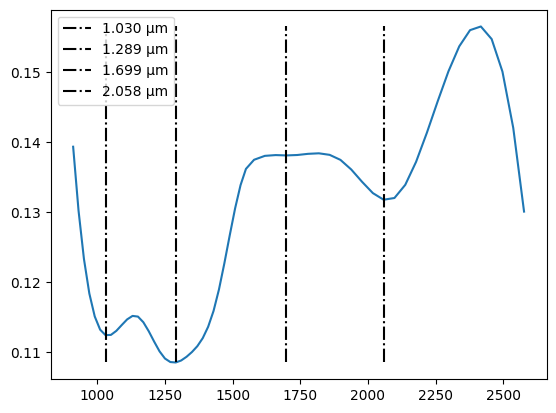

In [83]:
def get_minima(wvlValues:'np.ndarray',img:'np.ndarray',x:'int', y:'int') -> 'tuple':
    rflValues = img[x,y,:]
    fig, ax = plt.subplots(1, 1)
    ax.plot(wvlValues,rflValues)

    diff_list = []
    wvlMinima = ()
    for n in range(0, len(rflValues)):
        if n < len(rflValues)-1:
            diff = rflValues[n]-rflValues[n+1]
            diff_list.append(diff)
            if n > 2 and diff < 0 and diff_list[-2] > 0:
                (diff, diff_list[-2])
                print(
                    f"Differential: {diff} \nWavelength: {wvlValues[n]} \nReflectance: {rflValues[n]} \n")
                ax.vlines(wvlValues[n], min(rflValues), max(rflValues), color='k', ls='dashdot',
                            label=f'{wvlValues[n]/1000:.3f} \u03BCm')
                wvlMinima += (wvlValues[n],)

    ax.legend()
    
    ##Check if minima reflect water spectrum
    return wvlMinima

get_minima(allowedWvl,spectrumImage_cspl,91,100)

In [81]:
mytup = ()
for i in range(5):
    mytup += (1,)

mytup


(1, 1, 1, 1, 1)